<a href="https://colab.research.google.com/github/KasiBaskerLaxmanan/pyalgotrading/blob/master/MH_Hands_on_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgbfir

#cell magic to show on the browser.

%matplotlib inline 


from io import StringIO
import zipfile

from sklearn.experimental import enable_iterative_imputer
from sklearn import impute
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn import dummy, metrics, model_selection, preprocessing
from sklearn import tree 
import xgbfir
import xgboost as xgb
from yellowbrick import classifier
from yellowbrick import model_selection as ms_yb

     |████████████████████████████████| 143kB 3.8MB/s 


The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.


## Decision Trees
Going to classify Titanic passengers with a Decision Tree.
http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.html

In [ ]:

# make sure xlrd is installed
url = 'http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls'
titanic = pd.read_excel(url)

In [ ]:
titanic

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,0,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN


In [ ]:
titanic.dtypes
# int64 -- no missing values vs float64 --floating pt number missing or no missing, int type some of them missing
# object --- char vars, free form text, numbers as char
# boat and body are leaky variables.

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [ ]:
def clean_titanic(titanic):
    # for object columns figure out what to do
    titanic = titanic.drop(['name', 'ticket', 'home.dest', 'boat',
         'body', 'cabin'], axis=1)
    # Drop first as one column is linear combination of others
    titanic = pd.get_dummies(titanic, drop_first=True)
    return titanic

X = clean_titanic(titanic).dropna().drop(columns='survived')
y = clean_titanic(titanic).dropna().survived

In [ ]:
# baseline model - score is accuracy of labels
dc = dummy.DummyClassifier(random_state=42)
# Shift+tab
dc.fit(X, y)
dc.score(X, y)

The default value of strategy will change from stratified to prior in 0.24.


0.5425837320574163

In [ ]:
dt = tree.DecisionTreeClassifier()
dt.fit(X, y)
dt.score(X, y)

0.9789473684210527

## Lab Data
* Load Kaggle survey data
* Use pandas to create numeric data
* Create a binary classification dataset by limiting occupation to Data Scientist or Software Engineer


In [ ]:
# ## Lab Data 

#https://www.kaggle.com/kaggle/kaggle-survey-2018
url2='/content/kaggle-survey-2018.zip'
with zipfile.ZipFile(url2) as z:
    print(z.namelist())
    kag = pd.read_csv(z.open('multipleChoiceResponses.csv'))
    kag_questions = kag.iloc[0]
    raw = kag.iloc[1:]


# +
def tweak_kag(df):
    # What is your gender?
    q1 = pd.get_dummies(df[['Q1']], drop_first=True).iloc[:,:-2]
    # Age groups in years
    q2 = pd.to_numeric(df.Q2.str.slice(0,2)).rename('Q2_age')
    # Country
    q3 = pd.get_dummies(df[['Q3']], drop_first=True).loc[:,
        ['Q3_United States of America', 'Q3_India', 'Q3_China']]
    # Highest Education
    q4 = df.Q4.replace({'Master’s degree': 18,
 'Bachelor’s degree': 16,
 'Doctoral degree': 20,
 'Some college/university study without earning a bachelor’s degree': 13,
 'Professional degree': 19,
 'I prefer not to answer': None,
 'No formal education past high school': 12}).rename('Q4_edu')
    # Undergrad major
    q5 = df.Q5.replace({
        'Computer science (software engineering, etc.)': 'cs',
        'Engineering (non-computer focused)': 'eng',
        'Mathematics or statistics': 'stat'})
    q5[~q5.isin(['cs', 'eng', 'stat'])] = 'other'
    q5 = pd.get_dummies(q5, prefix='Q5', drop_first=True)
    # Title
    q6 = pd.get_dummies(df[['Q6']], drop_first=True).loc[:,
        ['Q6_Data Scientist', 'Q6_Software Engineer', 'Q6_Consultant',]]
    # Years experience
    q8 = pd.to_numeric(df.Q8.str.replace('+','')
                       .str.split('-', expand=True)
                       .iloc[:,0]
                       .rename('Q8_exp'))
    # Yearly compensation ($)
    q9 = pd.to_numeric(df.Q9.str.replace('+','')
                       .str.replace(',','')
                       .str.replace('500000', '500')
                       .str.replace('I do not wish to disclose my approximate yearly compensation','')
                       .str.split('-', expand=True)
                       .iloc[:,0]
                       .rename('Q9_salary')) * 1_000
    # Programming language
    q16 = pd.concat([df.Q16_Part_1.rename('Q16_Py').replace('Python', 1),
                     df.Q16_Part_2.rename('Q16_R').replace('R', 1),
                     df.Q16_Part_3.rename('Q16_SQL').replace('SQL', 1)
                    ], axis=1)
    return pd.concat([q1, q2, q3, q4, q5, q6, q8, q9, q16], axis=1)

kag = (tweak_kag(raw)
       #.fillna(0)
       .query('Q6_Consultant != 1')
       .drop(columns=['Q6_Consultant'])
      )
kag_X = kag.drop(columns=['Q6_Software Engineer', 'Q6_Data Scientist' ])
kag_y = kag['Q6_Data Scientist'] == 1

['SurveySchema.csv', 'freeFormResponses.csv', 'multipleChoiceResponses.csv']


Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types.Specify dtype option on import or set low_memory=False.


## Decision Tree Exercise
* Create a decision tree from the Kaggle data
* What is the score?

In [ ]:
kag_dt = tree.DecisionTreeClassifier()
# nan's what to do? 
# why data is missing
# also drop na's kag_X.dropna()
kag_dt.fit(kag_X.fillna(0), kag_y) #0.9436595302071595
#kag_dt.fit(kag_X.dropna(), kag_y) 
kag_dt.score(kag_X.fillna(0), kag_y) 



0.9436595302071595

## Splitting Data

In [ ]:
def get_train_test_X_y(titanic, size=.3):
    """We don't want to impute or standardize on the whole dataset
    else we are 'leaking' data"""
    y = titanic.survived
    X = titanic.drop(columns='survived')
    X_train, X_test, y_train, y_test = \
       model_selection.train_test_split(
       X, y, test_size=size, random_state=42,
       stratify=y)
    cols = X.columns

    # going to impute age and fare
    print("COL", cols)
    num_cols = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male']

    fi = impute.IterativeImputer() # KNN doesn't support .transform
    imputed_train = fi.fit_transform(X_train[num_cols])
    imputed_test = fi.transform(X_test[num_cols])
    
    X_train = X_train.assign(**{num_cols[i]: imputed_train[:,i]
                         for i in range(len(num_cols))})
    X_test = X_test.assign(**{num_cols[i]: imputed_test[:,i]
                         for i in range(len(num_cols))})
    
    cols = X_train.columns
    std = preprocessing.StandardScaler() 
    # Standardization -each col has mean value of 0, sd 1
    # Normalization -- scaling data between 0 and 1. very vague
    # Some models dont have to standardize -- dummy encoded variable
    # Normalize will skew if you have a lot of outliers, std will work.

    std_train = std.fit_transform(X_train) 
    std_test = std.transform(X_test)
    
    X_train = X_train.assign(**{cols[i]: std_train[:,i]
                               for i in range(len(cols))})
    X_test = X_test.assign(**{cols[i]: std_test[:,i]
                               for i in range(len(cols))})
    return X_train, X_test, y_train, y_test
    
url = 'http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls'
titanic = pd.read_excel(url)
titanic = clean_titanic(titanic)
X_train, X_test, y_train, y_test = get_train_test_X_y(titanic)


COL Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male', 'embarked_Q',
       'embarked_S'],
      dtype='object')


In [ ]:
# our model is overfitting!
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.7353689567430025

In [ ]:
dt.score(X_train, y_train)
# natural tendency to overfit, simplify or prune it or limit the depth.

0.9737991266375546

## Splitting Exercise
* Split the Kaggle data
* Build a model using the split data
* What is the score of the new model?

In [ ]:
kag_X_train, kag_X_test, kag_y_train, kag_y_test = model_selection.train_test_split(
    kag_X.fillna(0), kag_y, random_state=42, test_size=.3,
    stratify=kag_y
)
# statify -- keeps the same ratio of y the same lets say 0.5 and 0.5
# scikit vs tf --- tabular or structured --- xgboost
# 

In [ ]:
kag_dt = tree.DecisionTreeClassifier()
kag_dt.fit(kag_X_train, kag_y_train)
kag_dt.score(kag_X_test, kag_y_test)

0.7693196591073234

In [ ]:
kag_dt.score(kag_X_train, kag_y_train)


0.9502817163023961

## Model Evaluation

In [ ]:
dt.score(X_test, y_test)

0.7302798982188295

In [ ]:
metrics.accuracy_score(y_test, dt.predict(X_test))

0.7302798982188295

In [ ]:
metrics.accuracy_score(y_test, dt.predict(X_test))

0.7302798982188295

In [ ]:
y_test.value_counts()

0    243
1    150
Name: survived, dtype: int64

In [ ]:
classifier.confusion_matrix(dt, X_train, y_train, X_test, y_test, classes=['Died', 'Survived'])

TypeError: ignored

In [ ]:
classifier.classification_report(dt, X_train, y_train, X_test, y_test, classes=['Died', 'Survived'])

TypeError: ignored

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


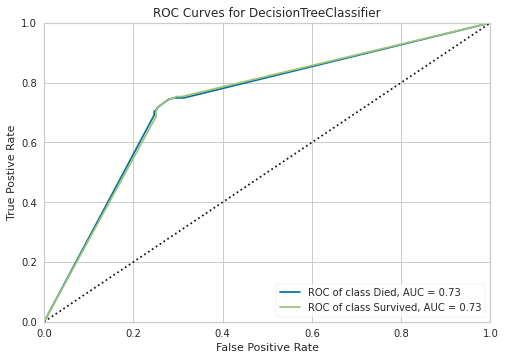

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f0112fda940>,
       classes=['Died', 'Survived'], encoder=None, force_model=False,
       is_fitted='auto', macro=False, micro=False, model=None, per_class=True)

In [ ]:
classifier.roc_auc(dt, X_train, y_train, X_test, y_test, classes=['Died', 'Survived'], micro=False, macro=False)

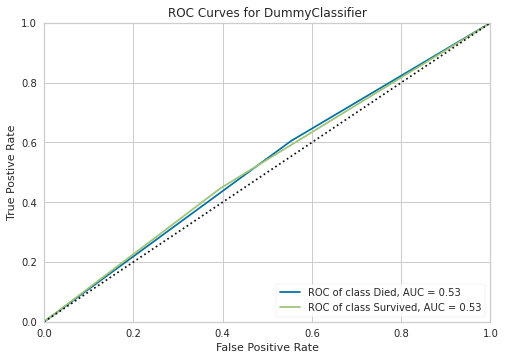

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f0113926400>,
       classes=['Died', 'Survived'], encoder=None, force_model=False,
       is_fitted='auto', macro=False, micro=False, model=None, per_class=True)

In [ ]:
classifier.roc_auc(dc, X_train, y_train, X_test, y_test, classes=['Died', 'Survived'], micro=False, macro=False)

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


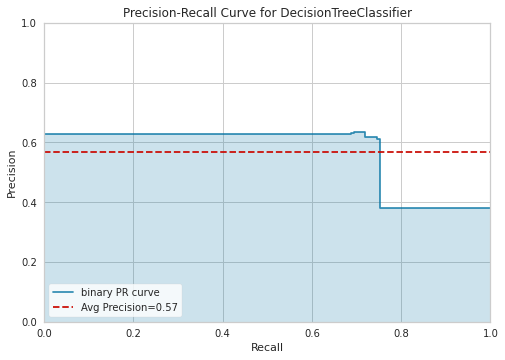

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


PrecisionRecallCurve(ap_score=True,
                     ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f01123d1908>,
                     classes=['Died', 'Survived'], encoder=None, fill_area=True,
                     fill_opacity=0.2, force_model=False, is_fitted='auto',
                     iso_f1_curves=False, iso_f1_values={0.2, 0.4, 0.6, 0.8},
                     line_opacity=0.8, micro=False, model=None,
                     per_class=False)

In [ ]:
classifier.precision_recall_curve(dt, X_train, y_train, X_test, y_test, classes=['Died', 'Survived'], micro=False, macro=False)

## Evaluation Exercise
* Create a Confusion Matrix for the Kaggle model
* Create an ROCAUC curve 
* Create a PrecisionRecall curve
* How is the model performing?

In [ ]:
kag_y.value_counts()

False    18937
True      4137
Name: Q6_Data Scientist, dtype: int64

In [ ]:
kag_y_train

6181     False
7027     False
14834    False
2531     False
10709    False
         ...  
23082    False
6723     False
17259    False
16204    False
18454    False
Name: Q6_Data Scientist, Length: 16151, dtype: bool

In [ ]:
classifier.confusion_matrix(kag_dt, kag_X_train, kag_y_train, classes=['SE', 'DS'])

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


ValueError: ignored

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


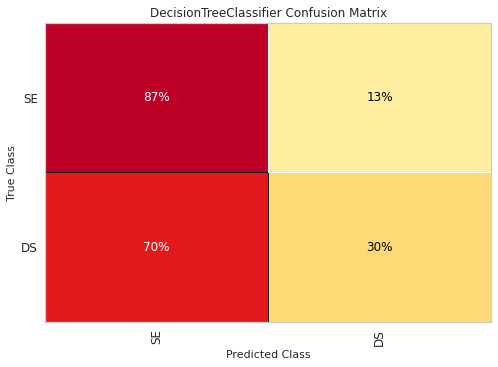

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ConfusionMatrix(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f01116a2160>,
                classes=['SE', 'DS'],
                cmap=<matplotlib.colors.ListedColormap object at 0x7f0112857ef0>,
                encoder=None, fontsize=None, force_model=False,
                is_fitted='auto', model=None, percent=True, sample_weight=None)

In [ ]:
classifier.confusion_matrix(kag_dt, kag_X_train, kag_y_train, kag_X_test, kag_y_test, 
                            percent=True, classes=['SE', 'DS'])

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


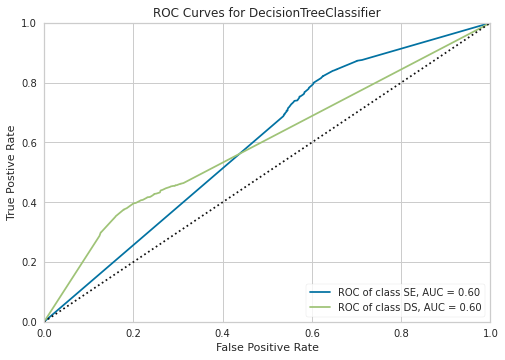

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f0111c03a58>,
       classes=['SE', 'DS'], encoder=None, force_model=False, is_fitted='auto',
       macro=False, micro=False, model=None, per_class=True)

In [ ]:
classifier.roc_auc(kag_dt, kag_X_train, kag_y_train, kag_X_test, kag_y_test, macro=False, micro=False,
                  classes=['SE', 'DS'])

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


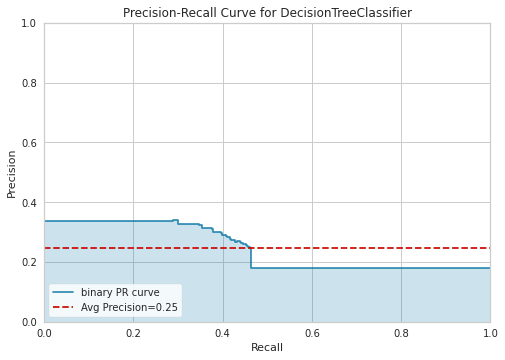

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


PrecisionRecallCurve(ap_score=True,
                     ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f01139a6ef0>,
                     classes=['SE', 'DS'], encoder=None, fill_area=True,
                     fill_opacity=0.2, force_model=False, is_fitted='auto',
                     iso_f1_curves=False, iso_f1_values={0.2, 0.4, 0.6, 0.8},
                     line_opacity=0.8, micro=False, model=None,
                     per_class=False)

In [ ]:
classifier.precision_recall_curve(kag_dt, kag_X_train, kag_y_train, kag_X_test, kag_y_test, macro=False, micro=False,
                  classes=['SE', 'DS'])
### if there is class imbalance then precision recall is better than auc/roc

## Tuning the Model

In [ ]:
stump = tree.DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)
stump.score(X_test, y_test)

0.7938931297709924

In [ ]:
dt4 = tree.DecisionTreeClassifier(max_depth=4)
dt4.fit(X_train, y_train)
dt4.score(X_test, y_test)

0.8346055979643766

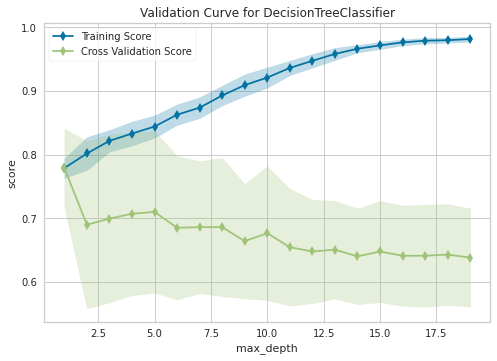

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f0104049208>,
                cv=None, groups=None, logx=False, model=None, n_jobs=1,
                param_name='max_depth',
                param_range=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                pre_dispatch='all', scoring=None)

In [ ]:
# can change scoring to optimize for different metrics
ms_yb.validation_curve(tree.DecisionTreeClassifier(), 
    X, y, param_name='max_depth', param_range=range(1, 20))

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


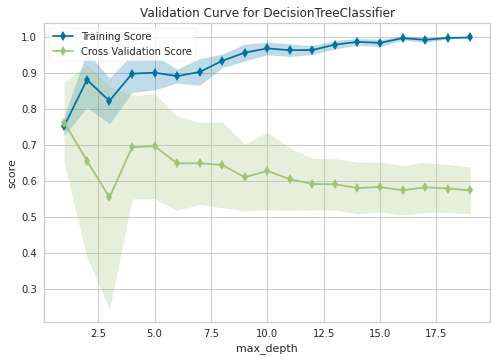

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f00fa70c6a0>,
                cv=None, groups=None, logx=False, model=None, n_jobs=1,
                param_name='max_depth',
                param_range=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                pre_dispatch='all', scoring='precision')

In [ ]:
# can change scoring to optimize for different metrics
ms_yb.validation_curve(tree.DecisionTreeClassifier(), 
    X, y, param_name='max_depth', param_range=range(1, 20),
                      scoring='precision')
# scoring parameter to vary different params

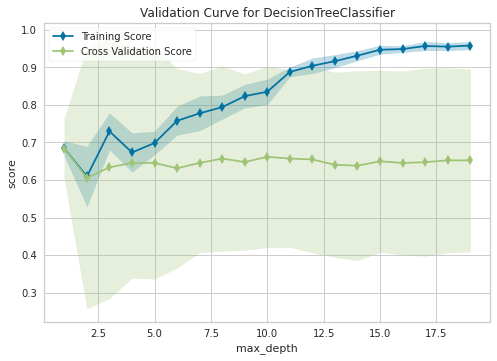

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f00fa5c5940>,
                cv=None, groups=None, logx=False, model=None, n_jobs=1,
                param_name='max_depth',
                param_range=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                pre_dispatch='all', scoring='recall')

In [ ]:
# can change scoring to optimize for different metrics
ms_yb.validation_curve(tree.DecisionTreeClassifier(), 
    X, y, param_name='max_depth', param_range=range(1, 20),
                      scoring='recall')

In [ ]:
param_grid = {'random_state': [42],
             'max_depth': [1,2,5,10,20],
             'min_impurity_decrease': [0, .1, .2, .5]}
grid = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid)
grid.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 2, 5, 10, 20],
                  

In [ ]:
grid.best_params_

{'max_depth': 1, 'min_impurity_decrease': 0, 'random_state': 42}

In [ ]:
best_dt = tree.DecisionTreeClassifier(**grid.best_params_)
best_dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

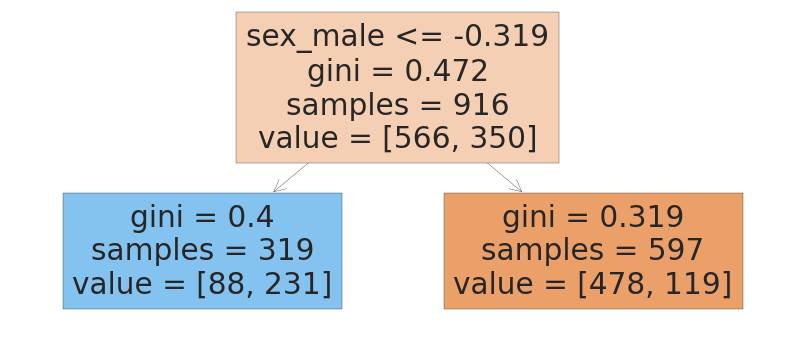

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
_=tree.plot_tree(best_dt, max_depth=2, filled=True, feature_names=X.columns, ax=ax)

## Tuning Exercise
* Run a visualization over your Kaggle model to evaluate the max_depth
* Run a grid search to evaluate max_depth

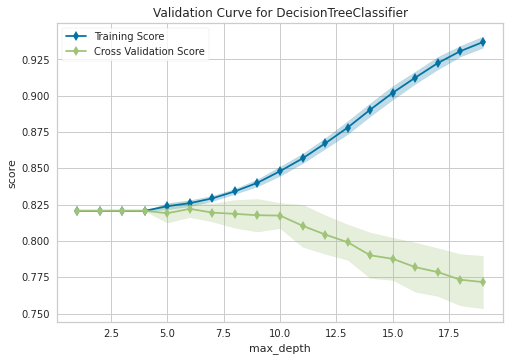

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f010fddebe0>,
                cv=None, groups=None, logx=False, model=None, n_jobs=1,
                param_name='max_depth',
                param_range=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                pre_dispatch='all', scoring=None)

In [ ]:
ms_yb.validation_curve(tree.DecisionTreeClassifier(random_state=42),  
    kag_X.fillna(0), kag_y, param_name='max_depth', param_range=range(1, 20))
# around 6 we have max score
# book website.
# https://learning.oreilly.com/library/view/machine-learning-pocket/9781492047537/

In [ ]:
param_grid = {'random_state': [42],
             'max_depth': [1,2,5,10,20],
             'min_impurity_decrease': [0, .1, .2, .5]}
grid = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid)
grid.fit(kag_X.fillna(0), kag_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 2, 5, 10, 20],
                  

In [ ]:
grid.best_params_

{'max_depth': 1, 'min_impurity_decrease': 0, 'random_state': 42}

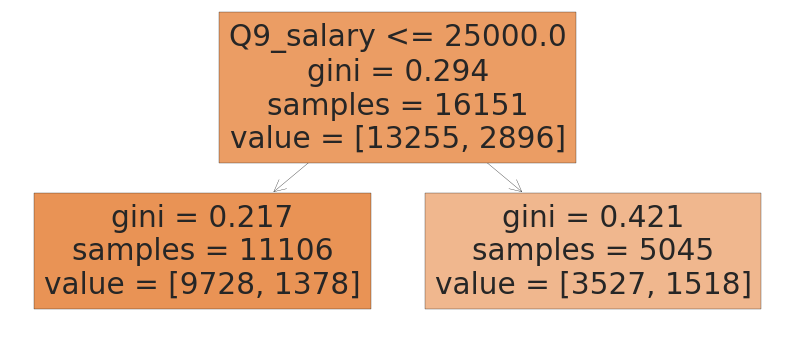

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
t2 = tree.DecisionTreeClassifier(**grid.best_params_)
t2.fit(kag_X_train, kag_y_train)
_=tree.plot_tree(t2, filled=True, feature_names=kag_X.columns, ax=ax)

## Explaining the Model

In [ ]:
dt

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


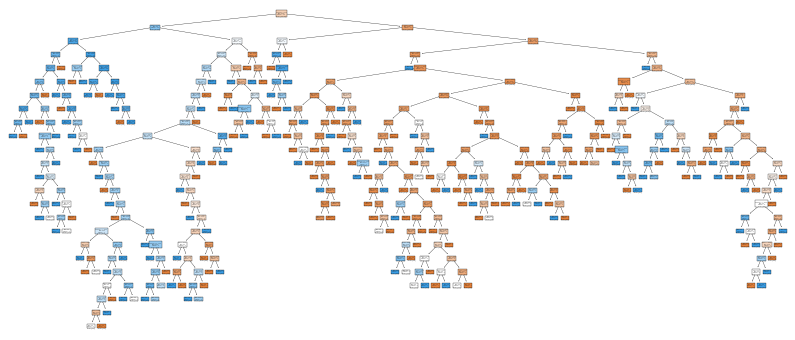

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
_=tree.plot_tree(dt, filled=True, feature_names=X.columns, ax=ax)

In [ ]:
dt.feature_importances_
# for each column how good is it

array([0.07349795, 0.26209984, 0.06581124, 0.02091557, 0.26959584,
       0.28372814, 0.00440774, 0.01994367])

In [ ]:
pd.Series(dt.feature_importances_, X.columns)

pclass        0.073498
age           0.262100
sibsp         0.065811
parch         0.020916
fare          0.269596
sex_male      0.283728
embarked_Q    0.004408
embarked_S    0.019944
dtype: float64

In [ ]:
# Shap - Interpret black box models
shap_ex = shap.TreeExplainer(dt)
vals = shap_ex.shap_values(X_test)

In [ ]:
# Row 0 predicts death... why?
dt.predict(X_test.iloc[[0]])

array([0])

In [ ]:
y_test.iloc[0]

0

In [ ]:
X_test.iloc[0]

pclass        0.834829
age          -0.625358
sibsp         0.525287
parch        -0.441482
fare         -0.527538
sex_male      0.730985
embarked_Q   -0.336157
embarked_S    0.675485
Name: 1289, dtype: float64

In [ ]:
X.loc[1289]

pclass         3.0000
age           21.0000
sibsp          1.0000
parch          0.0000
fare           6.4958
sex_male       1.0000
embarked_Q     0.0000
embarked_S     1.0000
Name: 1289, dtype: float64

In [ ]:
# Look at row 0
survive_idx = 1  # death = 0
shap.initjs()
shap.force_plot(shap_ex.expected_value[survive_idx], 
                vals[survive_idx][0,:], feature_names=X_test.columns)
# basevalue -- shap value is % of survived
# Fare is pushing more towards death, male as well higher age etc

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


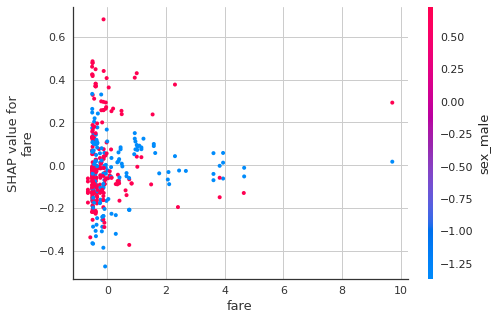

In [ ]:
# summary of fare
# As fare goes up shap tends toward slight negative
shap.dependence_plot('fare', shap_values=vals[survive_idx], features=X_test)
# red male, blue female as fare goes up 
# males with low fare are -ve shap
# females with low fare are also 

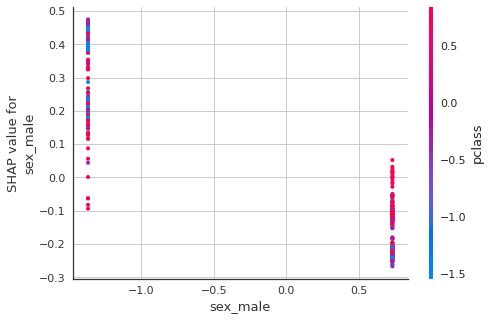

In [ ]:
# female - better survival
# male - better if you have a high pclass (but not much)
shap.dependence_plot('sex_male', shap_values=vals[survive_idx], features=X_test)

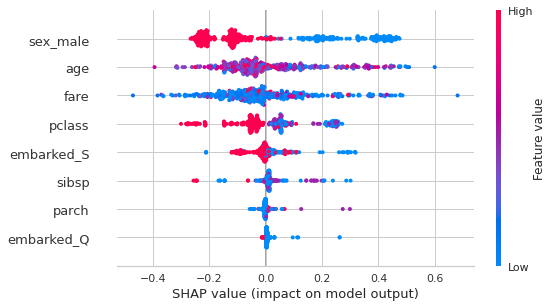

In [ ]:
shap.summary_plot(shap_values=vals[survive_idx], features=X_test)
# rank orders the features, 
# huge boost for females
# age does not have much diff
# fare has an interaction
# pclass is clearly imp

## Explaining the Model Exercise
* Create a decision tree visualization
* What are the important features?
* Use SHAP to explore a sample, the summary and the most important feature

In [ ]:
kag_dt = tree.DecisionTreeClassifier()
kag_dt.fit(kag_X_train, kag_y_train)
_=tree.plot_tree(kag_dt, filled=True, feature_names=kag_X.columns, ax=ax)

In [ ]:
tree.plot_tree(kag_dt, filled=True, feature_names=kag_X.columns, ax=ax)

[Text(486.6240683507709, 319.63680000000005, 'Q9_salary <= 25000.0\ngini = 0.294\nsamples = 16151\nvalue = [13255, 2896]'),
 Text(338.61731764802045, 306.59040000000005, 'Q5_stat <= 0.5\ngini = 0.217\nsamples = 11106\nvalue = [9728, 1378]'),
 Text(242.88597817955997, 293.54400000000004, 'Q9_salary <= 5000.0\ngini = 0.199\nsamples = 9855\nvalue = [8753, 1102]'),
 Text(147.03755028828712, 280.49760000000003, 'Q4_edu <= 17.0\ngini = 0.174\nsamples = 7836\nvalue = [7080, 756]'),
 Text(57.087243193670645, 267.45120000000003, 'Q16_R <= 0.5\ngini = 0.133\nsamples = 3727\nvalue = [3461, 266]'),
 Text(23.67047239407878, 254.40480000000002, 'Q4_edu <= 6.0\ngini = 0.117\nsamples = 3223\nvalue = [3022, 201]'),
 Text(4.3591189427312775, 241.35840000000002, 'Q5_other <= 0.5\ngini = 0.036\nsamples = 437\nvalue = [429, 8]'),
 Text(3.7518113500906973, 228.312, 'Q8_exp <= 0.5\ngini = 0.148\nsamples = 87\nvalue = [80, 7]'),
 Text(3.1849909302928223, 215.2656, 'Q16_SQL <= 0.5\ngini = 0.25\nsamples = 41\nvalue = [35, 6]'),
 Text(2.9690593417983937, 202.21920000000003, 'Q2_age <= 27.5\ngini = 0.291\nsamples = 34\nvalue = [28, 6]'),
 Text(2.051350090697072, 189.17280000000002, 'Q16_Py <= 0.5\ngini = 0.238\nsamples = 29\nvalue = [25, 4]'),
 Text(1.2955895309665717, 176.12640000000002, 'Q1_Male <= 0.5\ngini = 0.159\nsamples = 23\nvalue = [21, 2]'),
 Text(0.8637263539777145, 163.08, 'Q2_age <= 23.5\ngini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(0.6477947654832859, 150.03360000000004, 'Q3_China <= 0.5\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(0.43186317698885723, 136.98720000000003, 'Q2_age <= 20.0\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.21593158849442862, 123.94080000000002, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.6477947654832859, 123.94080000000002, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.8637263539777145, 136.98720000000003, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(1.079657942472143, 150.03360000000004, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(1.727452707955429, 163.08, 'Q2_age <= 20.0\ngini = 0.105\nsamples = 18\nvalue = [17, 1]'),
 Text(1.5115211194610003, 150.03360000000004, 'Q3_India <= 0.5\ngini = 0.375\nsamples = 4\nvalue = [3, 1]'),
 Text(1.2955895309665717, 136.98720000000003, 'gini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(1.727452707955429, 136.98720000000003, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(1.9433842964498576, 150.03360000000004, 'gini = 0.0\nsamples = 14\nvalue = [14, 0]'),
 Text(2.807110650427572, 176.12640000000002, 'Q2_age <= 23.5\ngini = 0.444\nsamples = 6\nvalue = [4, 2]'),
 Text(2.5911790619331434, 163.08, 'Q1_Male <= 0.5\ngini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(2.375247473438715, 150.03360000000004, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(2.807110650427572, 150.03360000000004, 'Q3_India <= 0.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(2.5911790619331434, 136.98720000000003, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(3.0230422389220006, 136.98720000000003, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(3.0230422389220006, 163.08, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(3.886768592899715, 189.17280000000002, 'Q3_China <= 0.5\ngini = 0.48\nsamples = 5\nvalue = [3, 2]'),
 Text(3.6708370044052865, 176.12640000000002, 'Q3_India <= 0.5\ngini = 0.5\nsamples = 4\nvalue = [2, 2]'),
 Text(3.454905415910858, 163.08, 'Q2_age <= 40.0\ngini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(3.2389738274164293, 150.03360000000004, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(3.6708370044052865, 150.03360000000004, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(3.886768592899715, 163.08, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(4.102700181394144, 176.12640000000002, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(3.400922518787251, 202.21920000000003, 'gini = 0.0\nsamples = 7\nvalue = [7, 0]'),
 Text(4.318631769888572, 215.2656, 'Q2_age <= 37.5\ngini = 0.043\nsamples = 46\nvalue = [45, 1]'),
 Text(4.

In [ ]:
pd.Series(kag_dt.feature_importances_, kag_X.columns)

Q1_Male                        0.057032
Q2_age                         0.167937
Q3_United States of America    0.044974
Q3_India                       0.030348
Q3_China                       0.016936
Q4_edu                         0.091880
Q5_eng                         0.041839
Q5_other                       0.048745
Q5_stat                        0.021372
Q8_exp                         0.176524
Q9_salary                      0.174481
Q16_Py                         0.048076
Q16_R                          0.048903
Q16_SQL                        0.030954
dtype: float64

In [ ]:
# Look at row 0
shap_ex = shap.TreeExplainer(kag_dt)
vals = shap_ex.shap_values(kag_X_test)
ds_idx = 1  # death = 0
shap.initjs()
shap.force_plot(shap_ex.expected_value[ds_idx], 
                vals[ds_idx][0,:], feature_names=kag_X_test.columns)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


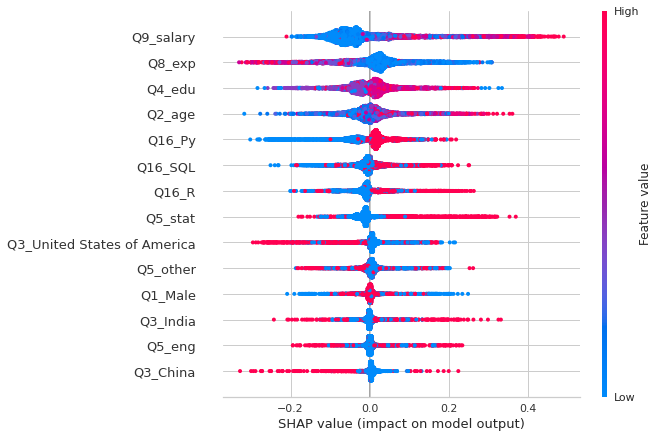

In [ ]:
shap.summary_plot(shap_values=vals[ds_idx], features=kag_X_test)

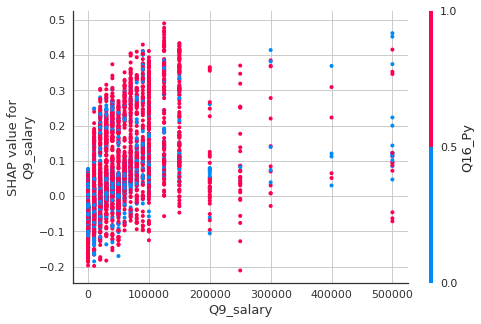

In [ ]:
# female - better survival
# male - better if you have a high pclass (but not much)
shap.dependence_plot('Q9_salary', shap_values=vals[ds_idx], features=kag_X_test)

In [ ]:
#https://scikit-learn.org/stable/inspection.html

## XGboost

In [ ]:
dt = tree.DecisionTreeClassifier(max_depth=None)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.7302798982188295

In [ ]:
xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)
xg.score(X_test, y_test)

0.8091603053435115

In [ ]:
xg

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

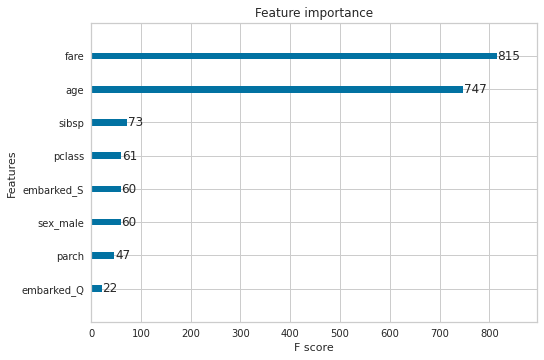

In [ ]:
xgb.plot_importance(xg)

In [ ]:
booster = xg.get_booster()
print(booster.get_dump()[0])

0:[sex_male<-0.318516761] yes=1,no=2,missing=1
	1:[pclass<0.240191877] yes=3,no=4,missing=3
		3:[fare<-0.213553071] yes=7,no=8,missing=7
			7:[fare<-0.248993397] yes=15,no=16,missing=15
				15:leaf=0.345454544
				16:leaf=-0
			8:[age<-2.02068782] yes=17,no=18,missing=17
				17:leaf=0.150000006
				18:leaf=0.536842108
		4:[fare<-0.186213404] yes=9,no=10,missing=9
			9:[age<-0.135106325] yes=19,no=20,missing=19
				19:[fare<-0.347762525] yes=25,no=26,missing=25
					25:[fare<-0.495176971] yes=35,no=36,missing=35
						35:leaf=0.180000007
						36:leaf=-0.111111112
					26:[embarked_S<-0.402466595] yes=37,no=38,missing=37
						37:leaf=0.375
						38:leaf=0.105882362
				20:[fare<-0.409403324] yes=27,no=28,missing=27
					27:[age<0.61912626] yes=39,no=40,missing=39
						39:leaf=-0.360000014
						40:leaf=0.0666666701
					28:[fare<-0.30063498] yes=41,no=42,missing=41
						41:leaf=0.163636371
						42:leaf=-0.150000006
			10:leaf=-0.400000036
	2:[age<-1.26645517] yes=5,no=6,missing=5
		

In [ ]:
booster = xg.get_booster()
print(booster.get_dump()[1])

0:[sex_male<-0.318516761] yes=1,no=2,missing=1
	1:[pclass<0.240191877] yes=3,no=4,missing=3
		3:[fare<-0.130015194] yes=7,no=8,missing=7
			7:[sibsp<0.018799752] yes=15,no=16,missing=15
				15:leaf=0.29026866
				16:[age<-0.323664486] yes=27,no=28,missing=27
					27:leaf=0.221128747
					28:[fare<-0.135584384] yes=41,no=42,missing=41
						41:leaf=0.139824614
						42:leaf=-0.0984348059
			8:leaf=0.426526964
		4:[fare<-0.186213404] yes=9,no=10,missing=9
			9:[age<-0.135106325] yes=17,no=18,missing=17
				17:[fare<-0.342741132] yes=29,no=30,missing=29
					29:[fare<-0.395184696] yes=43,no=44,missing=43
						43:leaf=0.114438705
						44:leaf=-0.132525384
					30:[embarked_S<-0.402466595] yes=45,no=46,missing=45
						45:leaf=0.34664309
						46:leaf=0.0817892998
				18:[fare<-0.409403324] yes=31,no=32,missing=31
					31:[age<0.61912626] yes=47,no=48,missing=47
						47:leaf=-0.288350314
						48:leaf=0.0555939935
					32:[age<0.242009968] yes=49,no=50,missing=49
						49:leaf=-0.0732665

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


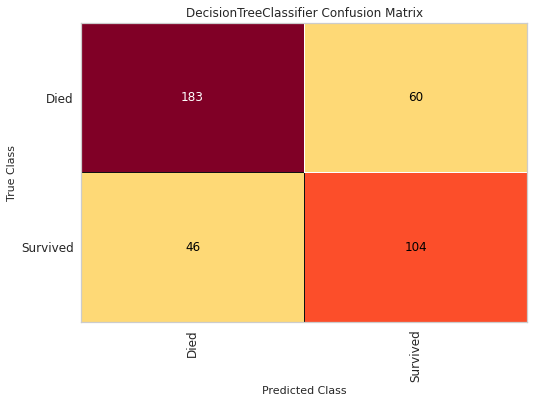

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ConfusionMatrix(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f010fd32208>,
                classes=['Died', 'Survived'],
                cmap=<matplotlib.colors.ListedColormap object at 0x7f0111e34ba8>,
                encoder=None, fontsize=None, force_model=False,
                is_fitted='auto', model=None, percent=False,
                sample_weight=None)

In [ ]:
classifier.confusion_matrix(dt, X_train, y_train, X_test, y_test, classes=['Died', 'Survived'])

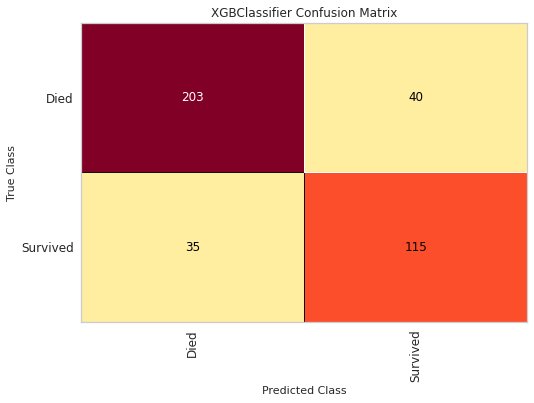

ConfusionMatrix(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f010fa34668>,
                classes=['Died', 'Survived'],
                cmap=<matplotlib.colors.ListedColormap object at 0x7f0113832cf8>,
                encoder=None, fontsize=None, force_model=False,
                is_fitted='auto', model=None, percent=False,
                sample_weight=None)

In [ ]:
classifier.confusion_matrix(xg, X_train, y_train, X_test, y_test, classes=['Died', 'Survived'])

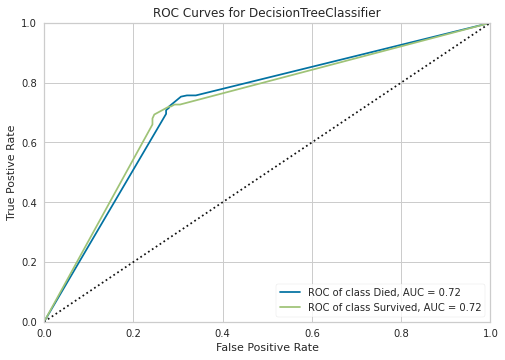

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f010fcc4a58>,
       classes=['Died', 'Survived'], encoder=None, force_model=False,
       is_fitted='auto', macro=False, micro=False, model=None, per_class=True)

In [ ]:
classifier.roc_auc(dt, X_train, y_train, X_test, y_test, classes=['Died', 'Survived'], micro=False, macro=False)

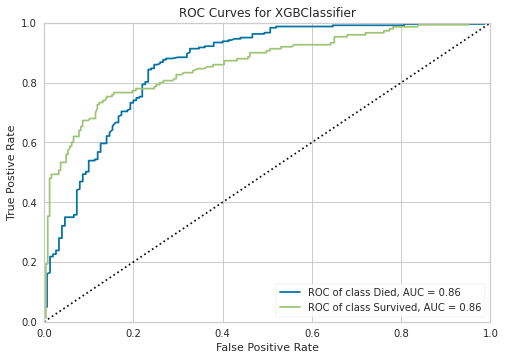

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f01062e1dd8>,
       classes=['Died', 'Survived'], encoder=None, force_model=False,
       is_fitted='auto', macro=False, micro=False, model=None, per_class=True)

In [ ]:
classifier.roc_auc(xg, X_train, y_train, X_test, y_test, classes=['Died', 'Survived'], micro=False, macro=False)

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


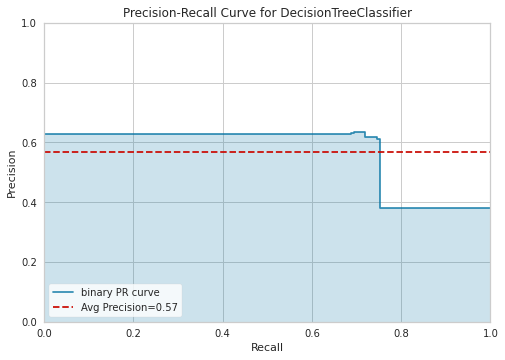

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


PrecisionRecallCurve(ap_score=True,
                     ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f01123d1908>,
                     classes=['Died', 'Survived'], encoder=None, fill_area=True,
                     fill_opacity=0.2, force_model=False, is_fitted='auto',
                     iso_f1_curves=False, iso_f1_values={0.2, 0.4, 0.6, 0.8},
                     line_opacity=0.8, micro=False, model=None,
                     per_class=False)

In [ ]:
classifier.precision_recall_curve(dt, X_train, y_train, X_test, y_test, classes=['Died', 'Survived'], micro=False, macro=False)

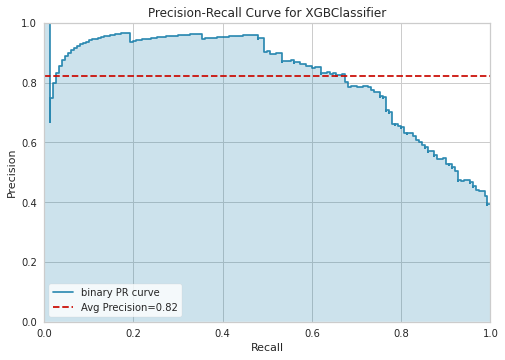

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


PrecisionRecallCurve(ap_score=True,
                     ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f0106675630>,
                     classes=['Died', 'Survived'], encoder=None, fill_area=True,
                     fill_opacity=0.2, force_model=False, is_fitted='auto',
                     iso_f1_curves=False, iso_f1_values={0.2, 0.4, 0.6, 0.8},
                     line_opacity=0.8, micro=False, model=None,
                     per_class=False)

In [ ]:
classifier.precision_recall_curve(xg, X_train, y_train, X_test, y_test, classes=['Died', 'Survived'], micro=False, macro=False)

In [ ]:
# Interactions
xgbfir.saveXgbFI(xg, feature_names=X.columns, OutputXlsxFile='fir-auto.xlsx')

In [ ]:
# column impmortance
# Gain - total gain of each feature
# Fscore - number of splits
# wFscore - weighted number of splits (by probability of split taking place)
pd.read_excel('fir-auto.xlsx').head(5).T

,0,1,2,3,4
Interaction,sex_male,fare,age,pclass,sibsp
Gain,528.332,523.507,397.461,166.371,96.9011
FScore,60,815,747,61,73
wFScore,41.1421,234.709,213.356,20.8519,15.9709
Average wFScore,0.685701,0.287987,0.285618,0.341834,0.21878
Average Gain,8.80554,0.64234,0.532076,2.72739,1.32741
Expected Gain,523.082,131.029,105.019,58.6213,11.6499
Gain Rank,1,2,3,4,5
FScore Rank,5,1,2,4,3
wFScore Rank,3,1,2,4,5


In [ ]:
# column impmortance
# Gain - total gain of each feature
# Fscore - number of splits
# wFscore - weighted number of splits (by probability of split taking place)
pd.read_excel('fir-auto.xlsx', sheet_name='Interaction Depth 1').head(5).T

,0,1,2,3,4
Interaction,pclass|sex_male,age|fare,fare|fare,age|sex_male,fare|pclass
Gain,656.066,593.221,530.791,516.708,373.114
FScore,18,498,396,53,63
wFScore,5.71764,95.8383,126.109,20.5949,16.3046
Average wFScore,0.317647,0.192446,0.318457,0.388584,0.258803
Average Gain,36.4481,1.19121,1.34038,9.74921,5.92245
Expected Gain,229.657,111.671,132.907,326.334,70.5836
Gain Rank,1,2,3,4,5
FScore Rank,15,1,2,7,5
wFScore Rank,13,3,1,4,5


In [ ]:
# column impmortance
# Gain - total gain of each feature
# Fscore - number of splits
# wFscore - weighted number of splits (by probability of split taking place)
pd.read_excel('fir-auto.xlsx', sheet_name='Interaction Depth 2').head(4).T

,0,1,2,3
Interaction,fare|pclass|sex_male,age|sex_male|sibsp,age|fare|fare,age|age|fare
Gain,1358.23,603.794,529.833,510.212
FScore,27,11,286,279
wFScore,5.00816,4.4307,59.6422,52.6462
Average wFScore,0.185487,0.402791,0.208539,0.188696
Average Gain,50.3046,54.8904,1.85256,1.82872
Expected Gain,238.178,56.0566,81.3588,86.4567
Gain Rank,1,2,3,4
FScore Rank,17,22,1,2
wFScore Rank,14,16,2,3


## XGBoost Exercise
With the Kaggle data
* Create an XGBoost model
* Evaluate the performance. What is the score?

In [ ]:
kag_xg = xgb.XGBClassifier()
kag_xg.fit(kag_X_train, kag_y_train)
kag_xg.score(kag_X_test, kag_y_test)

0.8198757763975155

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


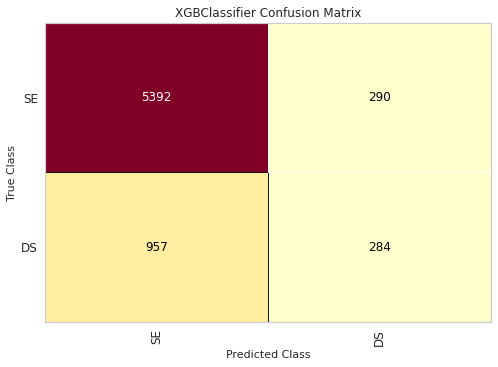

ConfusionMatrix(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f01043bd4e0>,
                classes=['SE', 'DS'],
                cmap=<matplotlib.colors.ListedColormap object at 0x7f01043e8fd0>,
                encoder=None, fontsize=None, force_model=False,
                is_fitted='auto', model=None, percent=False,
                sample_weight=None)

In [ ]:
classifier.confusion_matrix(kag_xg, kag_X_train, kag_y_train, kag_X_test, kag_y_test, classes=['SE', 'DS'])

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


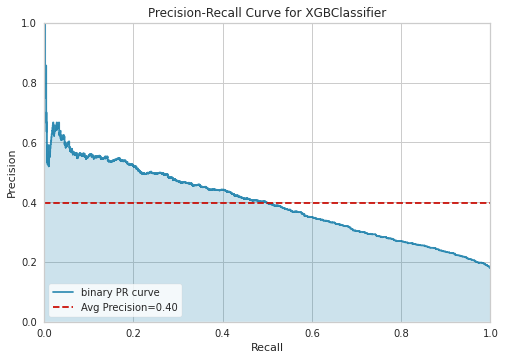

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


PrecisionRecallCurve(ap_score=True,
                     ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f01041929e8>,
                     classes=['SE', 'DS'], encoder=None, fill_area=True,
                     fill_opacity=0.2, force_model=False, is_fitted='auto',
                     iso_f1_curves=False, iso_f1_values={0.2, 0.4, 0.6, 0.8},
                     line_opacity=0.8, micro=True, model=None, per_class=False)

In [ ]:
classifier.precision_recall_curve(kag_xg, kag_X_train, kag_y_train, kag_X_test, kag_y_test, classes=['SE', 'DS'])

In [ ]:
t2 = tree.DecisionTreeClassifier(max_depth=1)
t2.fit(kag_X_train, kag_y_train)
t2.score(kag_X_test, kag_y_test)

0.8207424526939188

In [ ]:
metrics.confusion_matrix(kag_y_test, t2.predict(kag_X_test))

array([[5682,    0],
       [1241,    0]])

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


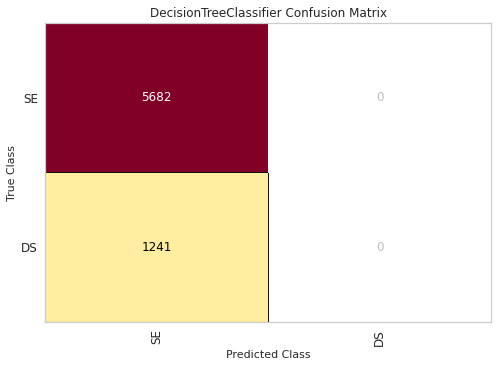

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ConfusionMatrix(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f0104195dd8>,
                classes=['SE', 'DS'],
                cmap=<matplotlib.colors.ListedColormap object at 0x7f010414a0b8>,
                encoder=None, fontsize=None, force_model=False,
                is_fitted='auto', model=None, percent=False,
                sample_weight=None)

In [ ]:
classifier.confusion_matrix(t2, kag_X_train, kag_y_train, kag_X_test, kag_y_test, classes=['SE', 'DS'])

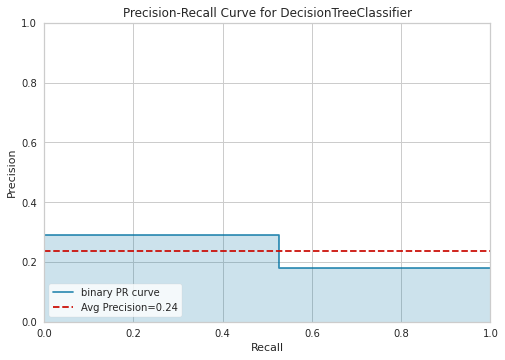

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


PrecisionRecallCurve(ap_score=True,
                     ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f01040de080>,
                     classes=['SE', 'DS'], encoder=None, fill_area=True,
                     fill_opacity=0.2, force_model=False, is_fitted='auto',
                     iso_f1_curves=False, iso_f1_values={0.2, 0.4, 0.6, 0.8},
                     line_opacity=0.8, micro=True, model=None, per_class=False)

In [ ]:
classifier.precision_recall_curve(t2, kag_X_train, kag_y_train, kag_X_test, kag_y_test, classes=['SE', 'DS'])